<center><h1>Autoregressive LSTM</h1></center>

In [1]:
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from sklearn.model_selection import TimeSeriesSplit
from functions import *

This notebook illustates how to 

# 1. Prepare the Data

The first thing we do is to prepare the data for the LSTM. We use $y_{t-1}, ..., y_{t-m}$ for $m$ timesteps to predict $y_t$. We start by format the data and forward filling. 

In [ ]:
# Import your data: First column Dates, second the Target value, 2: all other predictors
# # data = pd.read_csv("path", parse_dates=["Date"])

# Add Lagged Target: in case you want to predict y_t using y_{t-1}, ...
data = add_lagged_target(data)

# Select variables for the LSTM
# function to select variables
# Simple for now
exc = data.loc[:,["Date", "Target", "Lagged_target"]]

# Data
exc.iloc[:,2] = exc.iloc[:,2].ffill()
exc.iloc[0:3,2] = 0

Then we define a training set and a test set. We use $s = 12$ out-of-sample observations. 

In [5]:
# Define arrays for the network
X, y, date = data_formatter(exc, n_timesteps= 1)

# Print shapes
print(f"The shape of X is {X.shape}")
print(f"The shape of y is {y.shape}")

# The publication delay is zero for this variable given we already shifted it

# Samples
N = len(X)
print(f"In the dataset we have {N} month")
test_window = 12 
print(f"We use {test_window} as the length of the out-of-sample prediction")


X_cv, y_cv, dates_cv = X[:(N-test_window)], y[:(N-test_window)], date[:(N-test_window)]
X_test, y_test, dates_test = X[-test_window:], y[-test_window:], date[-test_window:]

The shape of X is (93, 1, 1)
The shape of y is (93,)
In the dataset we have 93 month
We use 12 as the length of the out-of-sample prediction


We use an expanding window approach. The following code shows the division of the months.

In [6]:
# Exemplary CV
tscv = TimeSeriesSplit(n_splits=4, test_size=12)
for i, (train_index, test_index) in enumerate(tscv.split(X_cv)):
    print(f"Fold {i}:")
    if i == 3:
        print(f"We use the last training one to store the model weigths")
    print(f"  Train: index={train_index}")
    print(f"  Valid:  index={test_index}")
# We use the last model weigths to perform the out-of-sample predictions

Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
  Valid:  index=[33 34 35 36 37 38 39 40 41 42 43 44]
Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
  Valid:  index=[45 46 47 48 49 50 51 52 53 54 55 56]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]
  Valid:  index=[57 58 59 60 61 62 63 64 65 66 67 68]
Fold 3:
We use the last training one to store the model weigths
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]
  Valid:  index=[69 70 71 72 73 74 75 76 77 78 79 80]


# 2. Train the LSTM

We train the LSTM. We compute the average MSE in the validation folds. Moreover, we store the weights of the last fold: so for each set of parameter we have saved the model weights. Hence we save the wigths of the model trained on:
* Training month: Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]
* Validation month: Valid:  index=[69 70 71 72 73 74 75 76 77 78 79 80]


In [7]:
# Set seed
set_seed(32)

# Parameter grid
hidden_size_grid = [16, 32]
num_layers_grid = [2, 3]
dropout_grid = [0]
batch_size_grid = [16, 32]

# Cross
results, plot_info = cross_validate(X_cv, y_cv, dates_cv, lr = 0.01, hidden_size_grid = hidden_size_grid, 
                                    num_layers_grid = num_layers_grid, dropout_grid = dropout_grid, 
                                    batch_size_grid = batch_size_grid, split = 4)

We show the dataset with the results and plot the last history for the 4th fold of the selected model. 

   hidden_size  num_layers  dropout  batch_size  average_valid_loss
0           32           2        0          32           15.116657
1           32           3        0          32           15.542141
2           16           3        0          32           15.632989
3           32           3        0          16           15.636009
4           32           2        0          16           15.734228


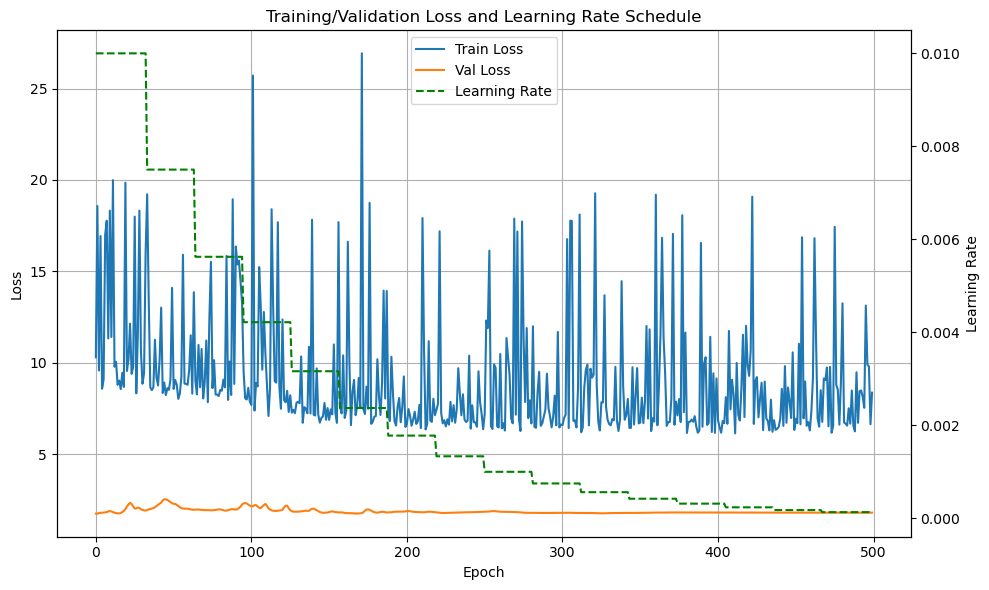

In [8]:
# Display losses
results, model_pth = get_results(results, plot_info)

# 3. Predict in out of sample

Finally, we perform the out-of-sample prediction


Test MSE: 1.3298132032946766


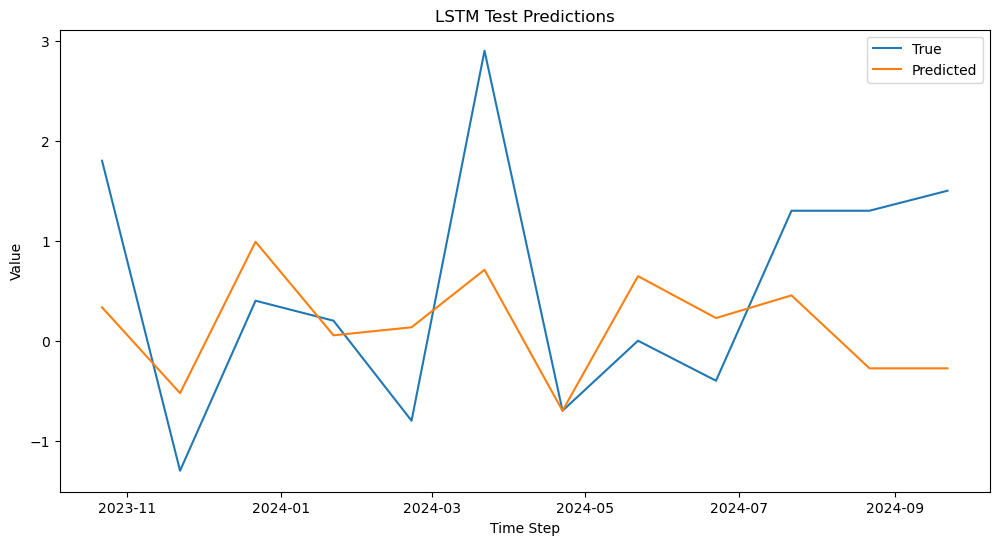

In [9]:
# Predict
mse = predict(X_test, y_test, dates_test, model_pth)